In [41]:
import pandas as pd
import numpy as np
from tqdm import tqdm as ProgressBar
from Born_Functions import Feature_Extraction
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from collections import defaultdict, Counter
from matplotlib import pyplot as plt
import seaborn as sns
from keras.datasets import cifar10
import cv2
from bornrule import BornClassifier
from sklearn.feature_extraction.text import TfidfTransformer
#import explanation_BORN
from matplotlib.gridspec import GridSpec
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
#FE = Feature_Extraction()

classifiers = {
    "BORN(0.5,1,1)": BornClassifier(0.5,1,1),
    "BORN(1,0,1)": BornClassifier(1,0,1),
    "BORN(0.5,1,0)": BornClassifier(0.5,1,0),
    "BORN(1,0,0)": BornClassifier(1,0,0)
    }
k=100

In [42]:
def extract_train_and_test(file_path):
    # Estrazione dei parametri dal nome del file
    file_name = os.path.basename(file_path)
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    
    histogram_train = np.array(data['histograms_train'])
    y_train = np.array(data['y_train'])
    histogram_test = np.array(data['histograms_test'])
    y_test = np.array(data['y_test'])
    
    return histogram_train, histogram_test, y_train, y_test

In [43]:
#SELECT Files

# file_path = 'Histograms_repository'
# file_names = [f"{file_path}/{f}" for f in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, f))]

# classifiers = {
#     "BORN(0.5,1,1)": BornClassifier(0.5,1,1),
#     "BORN(1,0,1)": BornClassifier(1,0,1),
#     "BORN(0.5,1,0)": BornClassifier(0.5,1,0),
#     "BORN(1,0,0)": BornClassifier(1,0,0)
#     }


# k_list = [100]
# dataset = 'CIFAR10'

# born_files = []
# for k in k_list:
    
#     for i in range(len(file_names)):
#         Hist, rc, extr, dist, vv = file_names[i].split("_")
#         if extr == 'SIFT' and rc[11:] == dataset and dist == 'euclidean'and vv[:-4] == str(k): 
#             born_files.append(file_names[i])

#     born_files

# born_files

#OR

born_files = ['cifar_resnet_100', 'cifar_detr_res_100', 'cifar_detr_pixel_100', 'Histograms_repository/CIFAR10_SIFT_euclidean_100.pkl']


default_conf = born_files[3]
xt, xp, yt, yp = extract_train_and_test(default_conf)

['Histograms_repository/CIFAR10_SIFT_euclidean_100.pkl']

In [45]:
classifier = classifiers['BORN(0.5,1,1)']
classifier.fit(xt, yt)
y_pred = classifier.predict(xp)
print("f1 score", f1_score(yp, y_pred, average='macro'))
cm = confusion_matrix(yp, y_pred)

f1 score 0.17351837993750954


<Axes: >

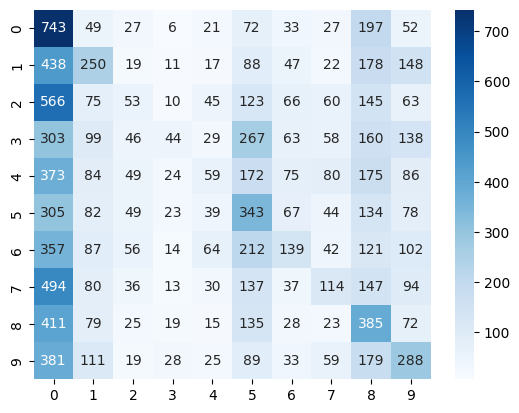

In [46]:
sns.heatmap(cm, cmap='Blues', annot = True, fmt=".0f")

<Axes: >

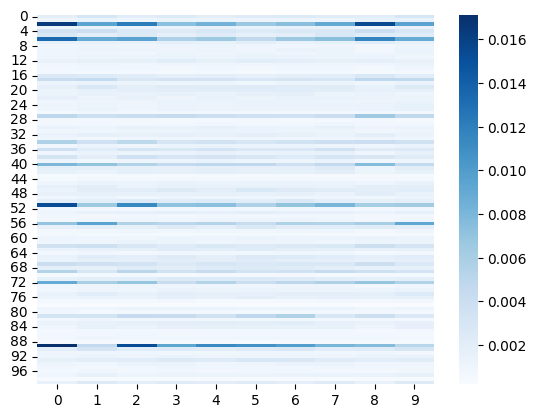

In [47]:
sns.heatmap(classifier.explain(), cmap='Blues')

### Local Explanation

In [48]:
#Extract elements of each class

df = pd.DataFrame(columns=['histograms', 'labels'])
histograms = np.concatenate((xt, xp), axis=0)
labels = np.concatenate((yt, yp), axis=0)
df['histograms'] = [histograms[i] for i in range(histograms.shape[0])]
df['labels'] = labels
df.head()

## divide histograms by labels
histograms_by_label = {}
for label, group in df.groupby('labels'):
    histograms_by_label[label] = np.vstack(group['histograms'].values)

# ## divide histograms by labels
# histograms_by_label = {}
# for label, group in df.groupby('labels'):
#     histograms_by_label[label] = np.vstack(group['histograms'].values)

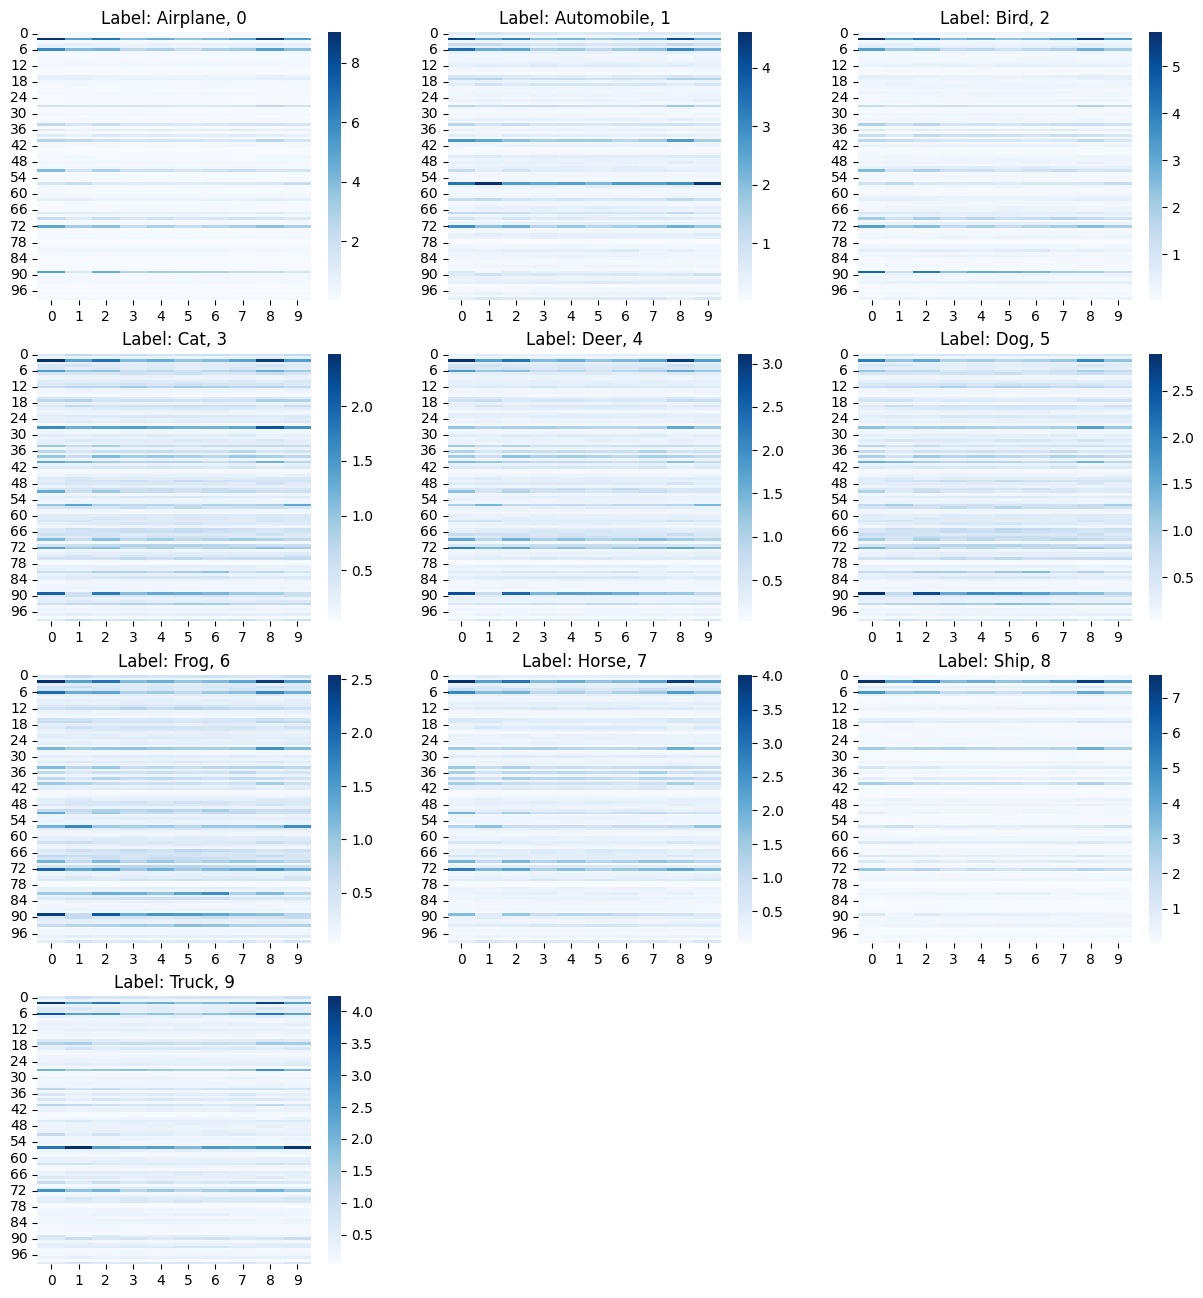

In [50]:
## PLOT
num_labels= len(np.unique(df.labels))
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
name_labels = [class_names[label] for label in range(num_labels)]

cols = 3  
rows = (num_labels + cols - 1) // cols  

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()  

class_explanation = []
for i, label in enumerate(np.unique(df.labels)):
    explanation = classifier.explain(histograms_by_label[label]) 
    class_explanation.append(explanation)
    sns.heatmap(explanation, ax=axes[i], cmap='Blues') 
    axes[i].set_title(f"Label: {name_labels[label]}, {i}") 

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)


plt.title(f"Local explanation, k: {k}")
plt.show()

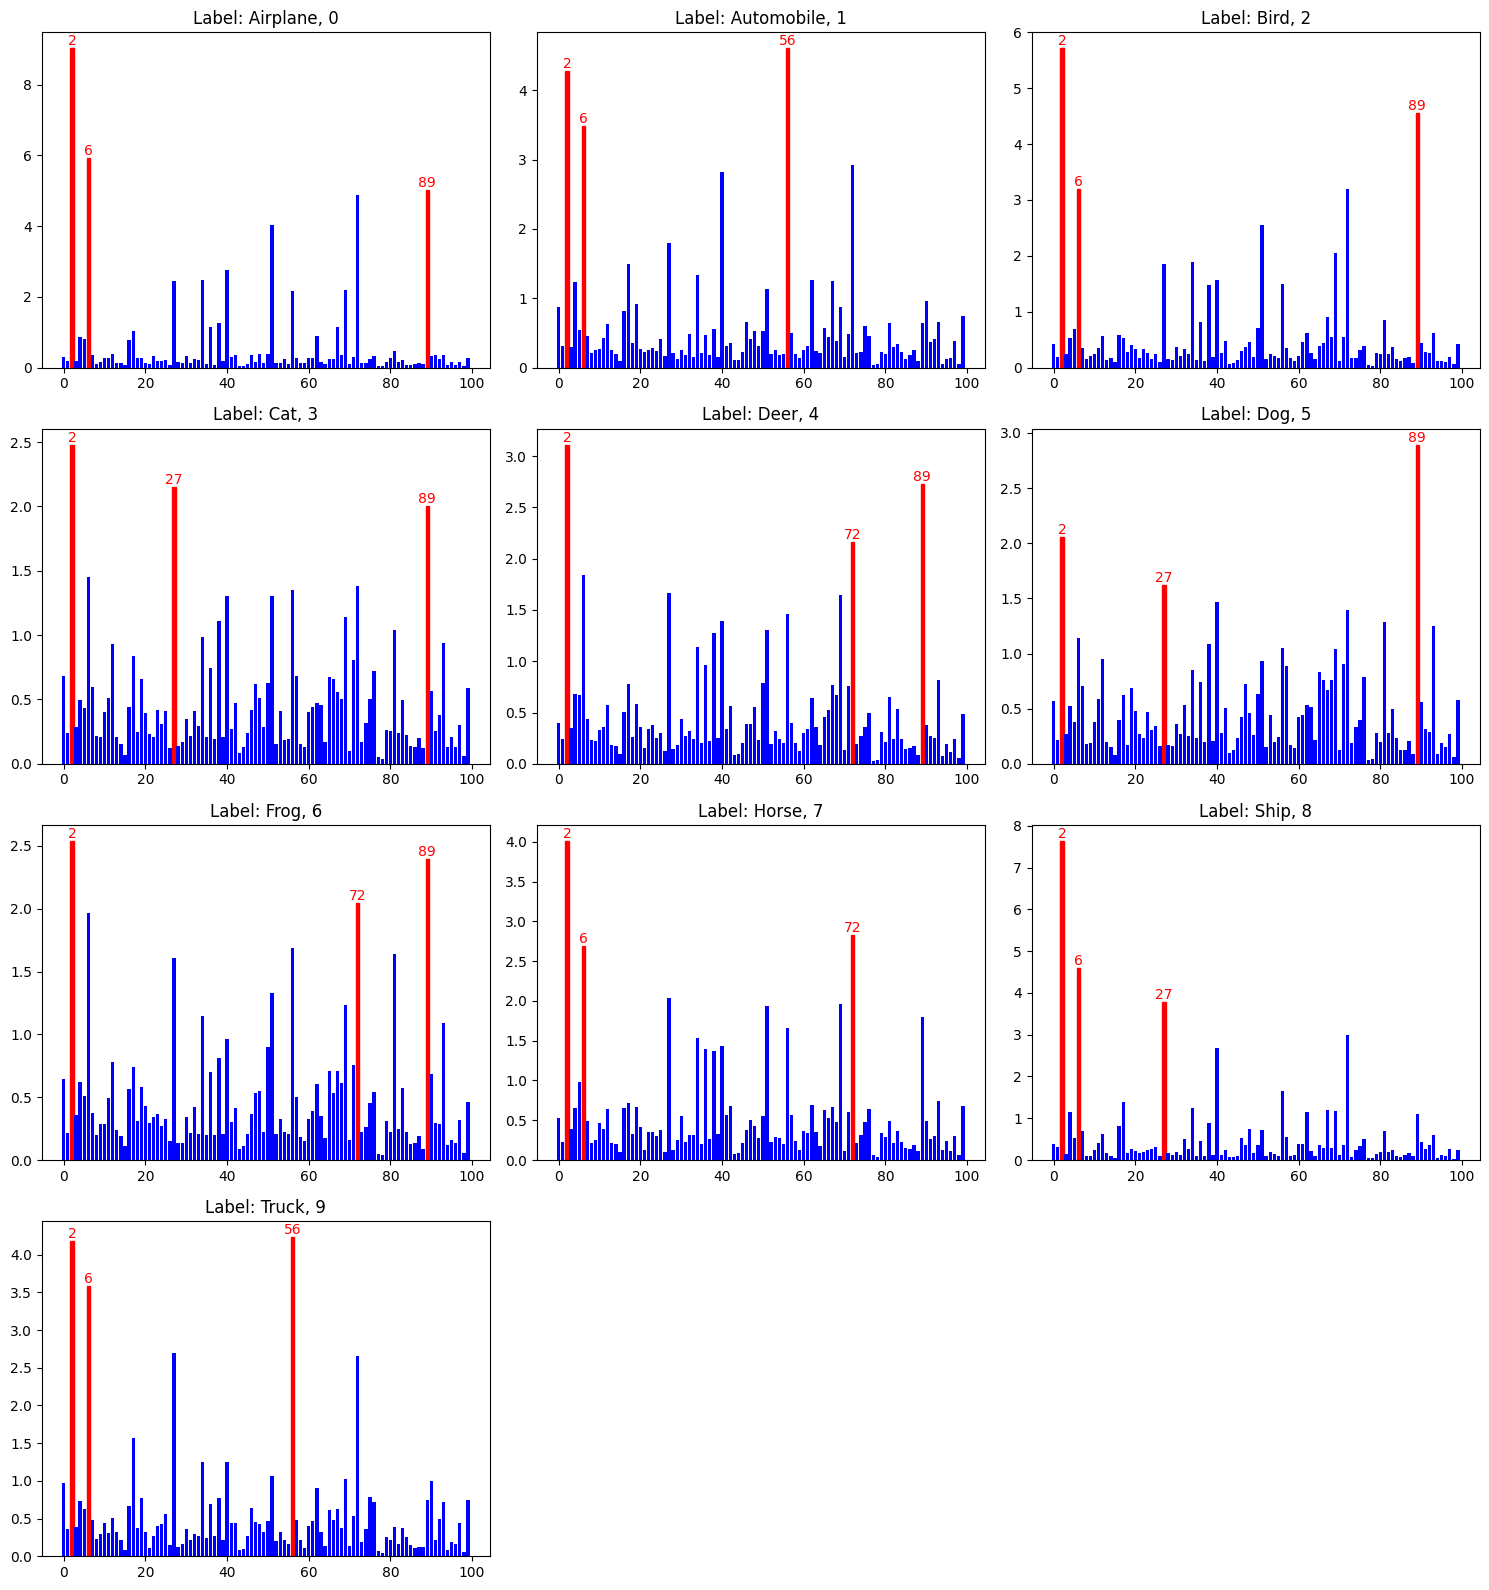

In [52]:
## FEATURE HISTOGRAMS
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()  

for i, label in enumerate(np.unique(df.labels)):
    explanation = classifier.explain(histograms_by_label[label]) 
    max_values = np.max(explanation, axis=1)
    

    top_indices = np.argsort(max_values)[-3:]  # top 3 indices
    top_values = max_values[top_indices]

    bars = axes[i].bar(range(len(max_values)), max_values, color='blue')
    for idx in top_indices:
        bars[idx].set_color('red') 

    for idx in top_indices:
        axes[i].text(idx, max_values[idx], f'{idx}', ha='center', va='bottom', color='red')

    axes[i].set_title(f"Label: {name_labels[label]}, {i}") 

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

#fig.suptitle(f'Maximum Explanation Values by Class, k = {k}', fontsize=16)
plt.tight_layout()
plt.show()


In [31]:
max_values = np.argmax(explanation, axis=0)

In [32]:
np.argmax(np.max(explanation, axis=0))

9

In [33]:
#extract most influential vw for each configuration:
conf, label_, top3 = [], [], []

classifiers = {
    "BORN(0.5,1,1)": BornClassifier(0.5,1,1),
    "BORN(1,0,1)": BornClassifier(1,0,1),
    "BORN(0.5,1,0)": BornClassifier(0.5,1,0),
    "BORN(1,0,0)": BornClassifier(1,0,0)
    }

for classifier_ in classifiers:
    classifier = classifiers[classifier_]
    classifier.fit(xt, yt)
    for label in np.unique(df.labels):
        explanation = classifier.explain(histograms_by_label[label]) 
        max_values = np.argmax(np.max(explanation, axis=0))
        top_indices = np.argsort(max_values)[-3:]
        top_values = max_values[top_indices]

        conf.append(classifier_)
        label_.append(label)
        top3.append((max_values))
        


In [34]:
df_local_top3 = pd.DataFrame({'Born configuration': conf, 'image class': label_, 'influential features': top3})
print(df_local_top3)

   Born configuration  image class  influential features
0       BORN(0.5,1,1)            0                     0
1       BORN(0.5,1,1)            1                     1
2       BORN(0.5,1,1)            2                     4
3       BORN(0.5,1,1)            3                     3
4       BORN(0.5,1,1)            4                     4
5       BORN(0.5,1,1)            5                     5
6       BORN(0.5,1,1)            6                     4
7       BORN(0.5,1,1)            7                     7
8       BORN(0.5,1,1)            8                     8
9       BORN(0.5,1,1)            9                     9
10        BORN(1,0,1)            0                     0
11        BORN(1,0,1)            1                     1
12        BORN(1,0,1)            2                     0
13        BORN(1,0,1)            3                     5
14        BORN(1,0,1)            4                     7
15        BORN(1,0,1)            5                     5
16        BORN(1,0,1)          

In [ ]:
#Counter(df_local_top3.groupby(['Born configuration']).sum()[0])
df_local_top3[df_local_top3['Born configuration'] == 'BORN(0.5,1,1)']['influential features']


#len(df_grpb['influential features'][0])

0     [2, 6, 89]
1     [2, 6, 56]
2     [2, 6, 89]
3    [2, 27, 89]
4    [2, 72, 89]
5    [2, 27, 89]
6    [2, 72, 89]
7     [2, 6, 72]
8     [2, 6, 27]
9     [2, 6, 56]
Name: influential features, dtype: object

# OLD

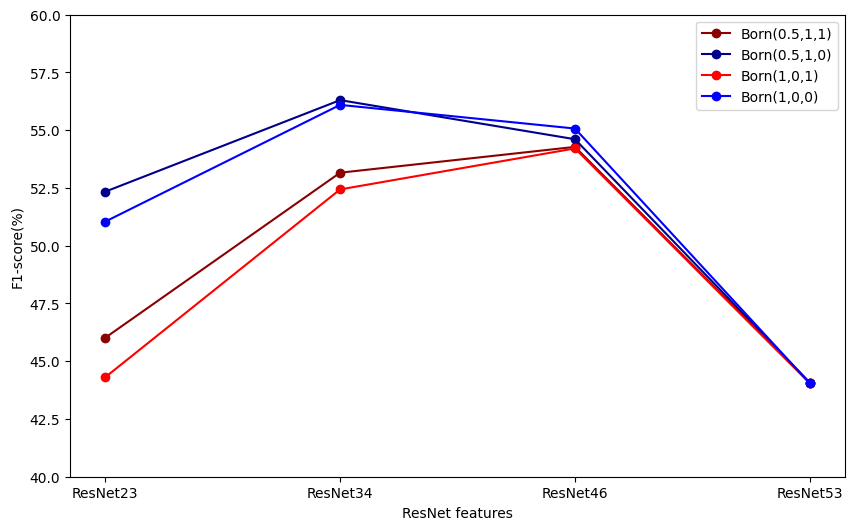

In [60]:
import matplotlib.pyplot as plt

# Dati
classifiers = ["Born(0.5,1,1)", "Born(0.5,1,0)", "Born(1,0,1)", "Born(1,0,0)"]
resnet_cols = ["ResNet23", "ResNet34", "ResNet46", "ResNet53"]
values = [
    [46.015, 53.161, 54.279, 44.071],  # Born(0.5,1,1)
    [52.340, 56.303, 54.610, 44.071],  # Born(0.5,1,0)
    [44.307, 52.437, 54.212, 44.045],  # Born(1,0,1)
    [51.044, 56.097, 55.073, 44.045]   # Born(1,0,0)
]

# Colori
colors = ["Darkred", "Darkblue", "red", "blue"]

# Creazione del grafico a linee
plt.figure(figsize=(10, 6))
for idx, (classifier, value) in enumerate(zip(classifiers, values)):
    plt.plot(resnet_cols, value, marker='o', label=classifier, color=colors[idx])

plt.xlabel('ResNet features')
plt.ylabel('F1-score(%)')
plt.ylim(40, 60) 
#plt.title('Performance of Born Configurations across ResNet Variants')
plt.legend()
#plt.grid(True)
plt.show()


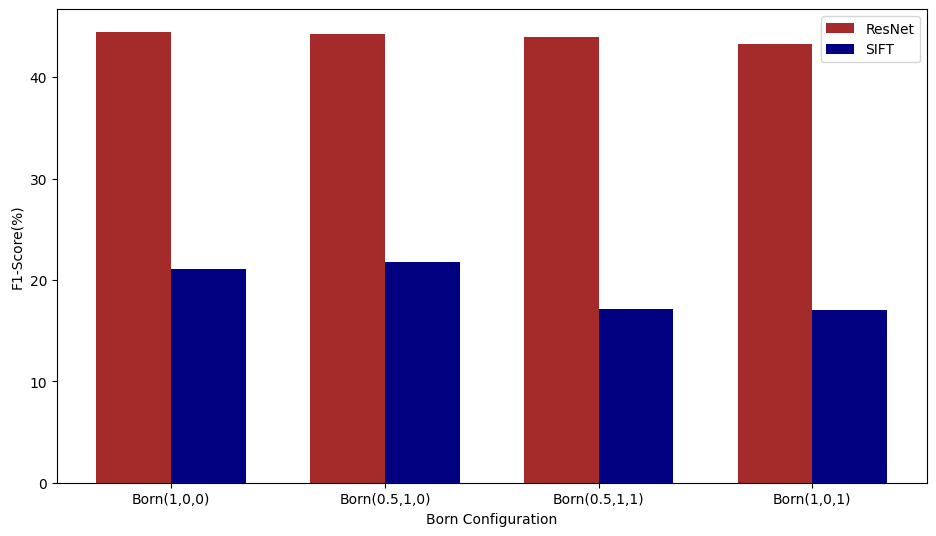

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Dati
configurations = ["Born(1,0,0)", "Born(0.5,1,0)", "Born(0.5,1,1)", "Born(1,0,1)"]
resnet_values = [44.471, 44.238, 43.944, 43.290]
sift_values = [21.089, 21.727, 17.116, 17.036]

# Posizioni delle configurazioni sulle x
x = np.arange(len(configurations))

# Larghezza delle barre
width = 0.35

# Creazione del grafico a barre
fig, ax = plt.subplots(figsize=(10, 6))

# Barre per ResNet
bars1 = ax.bar(x - width/2, resnet_values, width, label='ResNet', color='brown')

# Barre per SIFT
bars2 = ax.bar(x + width/2, sift_values, width, label='SIFT', color='navy')

# Etichette e titolo
ax.set_xlabel('Born Configuration')
ax.set_ylabel('F1-Score(%)')
#ax.set_title('Performance by Born Configuration for ResNet and SIFT')
ax.set_xticks(x)
ax.set_xticklabels(configurations)
ax.legend()

plt.tight_layout(pad=3.0)

# Mostra il grafico
#plt.grid(True)
plt.show()
